In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import statsmodels.api as sm
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [2]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity_cosine"

In [3]:
dataset = "2021-05-27-0"
estim = "data005/data005-all"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [4]:
wnoise = "kilosort_data001/data001"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [5]:
patterns = np.array([2])
n = 593

p_thr = 0.08
random_state = 0

In [6]:
all_elecs = []

for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]

    good_inds = np.where(triplet_probs > p_thr)[0]
    all_elecs.append(triplet_elecs)

Pattern 2


In [7]:
len(good_inds)

2255

/tmp/ipykernel_42148/1297822682.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


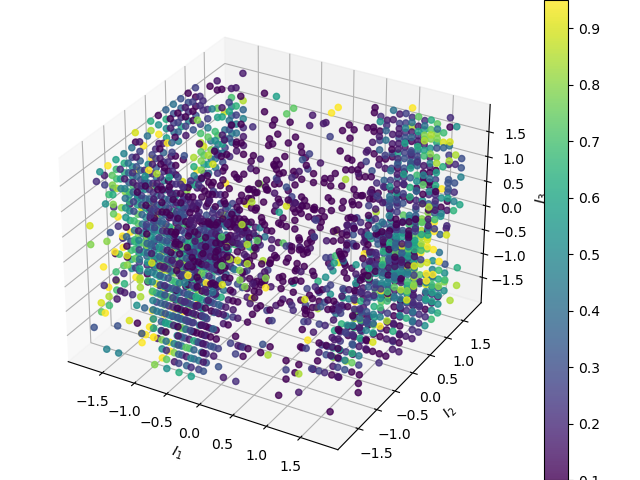

In [8]:
fig = plt.figure(0)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)

clb = plt.colorbar(scat)
plt.show()

In [9]:
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', affinity='nearest_neighbors', random_state=random_state).fit(amplitudes[good_inds])

/tmp/ipykernel_42148/933349295.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


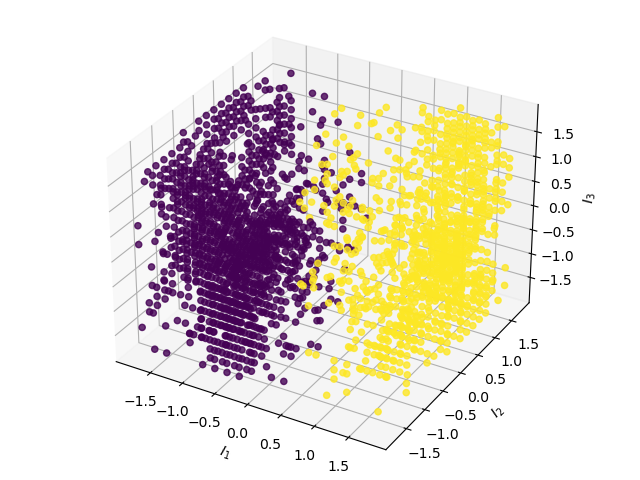

In [10]:
fig = plt.figure(1)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], marker='o', s=20, c=clustering.labels_, alpha=0.8)

plt.show()

In [11]:
all_elecs_array = np.unique(np.array(all_elecs))

In [12]:
all_elecs_array

array([429, 438, 439], dtype=uint16)

In [13]:
degree = 2
poly = PolynomialFeatures(degree)
X = poly.fit_transform(amplitudes[good_inds][np.where(clustering.labels_ == 0)[0]])
y = triplet_probs[good_inds][np.where(clustering.labels_ == 0)[0]]

In [14]:
logit = sm.Logit(y, X)

In [15]:
res_logit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.568466
         Iterations 6


In [16]:
print(res_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1273
Model:                          Logit   Df Residuals:                     1263
Method:                           MLE   Df Model:                            9
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                -0.01440
Time:                        16:18:39   Log-Likelihood:                -723.66
converged:                       True   LL-Null:                       -713.38
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9274      0.343     -5.622      0.000      -2.599      -1.255
x1            -0.1400      0.524     -0.267      0.789      -1.168       0.888
x2            -0.3320      0.242     -1.374      0.1

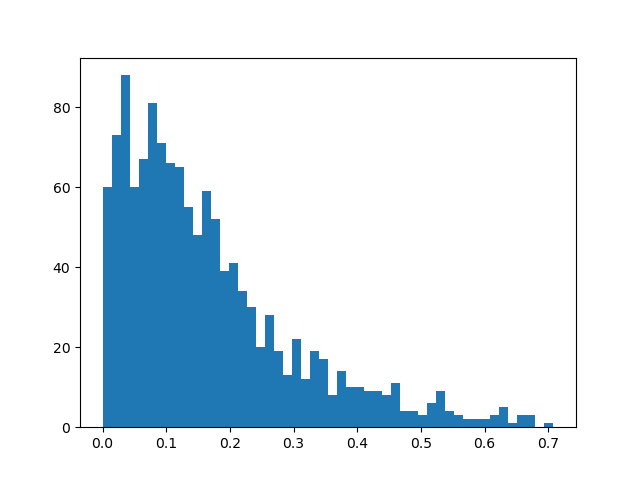

In [17]:
fig = plt.figure(9)
fig.clear()
plt.hist(np.absolute(fitting.fsigmoid(X, res_logit.params) - y), bins=50)
plt.show()

In [18]:
np.mean(np.absolute(fitting.fsigmoid(X, res_logit.params) - y) < 0.1)

0.394344069128044

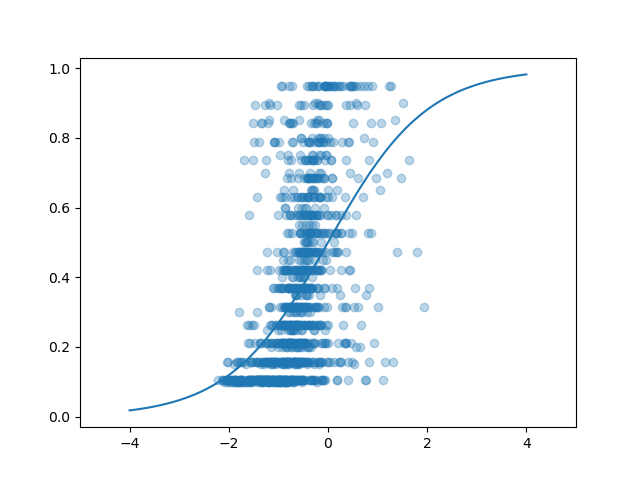

In [19]:
fig = plt.figure(8)
fig.clear()
sigmoid_x = np.linspace(-4, 4, 100)
plt.xlim(-5, 5)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))
plt.scatter(X @ res_logit.params, y, alpha=0.3)
plt.show()

In [36]:
X_pos = []
y_pos = []

X_neg = []
y_neg = []

trials_pos = []
trials_neg = []

Pattern 2


/tmp/ipykernel_42148/3052272972.py:29: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


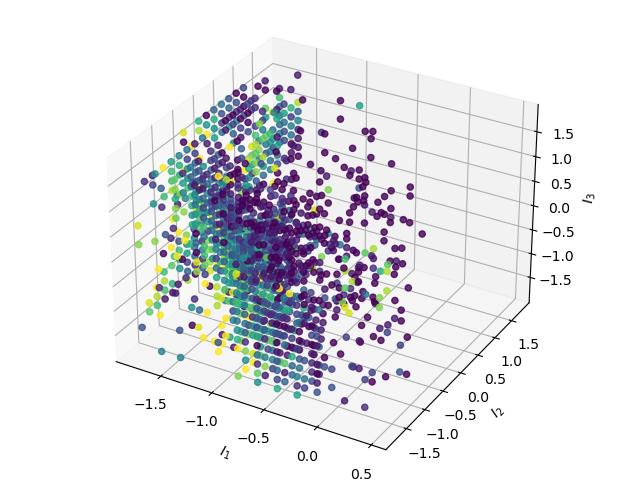

[429 438 439]
[429 439 438]
[0 2 1]
[[ 0.84375 -0.09375 -0.09375]
 [ 1.03125 -0.09375 -0.09375]
 [ 1.21875 -0.09375 -0.09375]
 ...
 [ 1.78125  1.59375  1.78125]
 [ 1.03125  1.78125  1.78125]
 [ 1.59375  1.78125  1.78125]]
[[ 0.84375 -0.09375 -0.09375]
 [ 1.03125 -0.09375 -0.09375]
 [ 1.21875 -0.09375 -0.09375]
 ...
 [ 1.78125  1.78125  1.59375]
 [ 1.03125  1.78125  1.78125]
 [ 1.59375  1.78125  1.78125]]
[0.25       0.4        0.55       0.6        0.35       0.4
 0.5        0.1        0.25       0.2        0.2        0.15
 0.2        0.25       0.25       0.1        0.2        0.1
 0.1        0.1        0.1        0.1        0.2        0.1
 0.1        0.15       0.2        0.15       0.1        0.35
 0.15       0.1        0.3        0.15       0.35       0.5
 0.7        0.55       0.6        0.25       0.3        0.2
 0.1        0.6        0.15       0.35       0.65       0.45
 0.25       0.45       0.8        0.95       0.2        0.1
 0.15       0.3        0.35       0.8        0.55

In [37]:
for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    triplet_trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]
            triplet_trials[k] = prob_dict["num_trials"]
    
    elec_inds = np.searchsorted(all_elecs_array, triplet_elecs)
    good_inds = np.where(triplet_probs > p_thr)[0]
    clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', affinity='nearest_neighbors', random_state=random_state).fit(amplitudes[good_inds])

    cluster1 = good_inds[np.where(clustering.labels_ == 0)[0]]
    cluster2 = good_inds[np.where(clustering.labels_ == 1)[0]]

    fig = plt.figure(5)
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(amplitudes[:, 0][cluster1], 
                amplitudes[:, 1][cluster1],
                amplitudes[:, 2][cluster1], marker='o', s=20, c=triplet_probs[cluster1], alpha=0.8)

    plt.show()

    y = triplet_probs[cluster1]
    X = amplitudes[cluster1]
    trials = triplet_trials[cluster1]
    X_pos_p = np.zeros((len(cluster1), len(all_elecs_array)))
    X_pos_p[:, elec_inds] = X
    X_pos.append(X_pos_p)
    y_pos.append(y)
    trials_pos.append(trials)

    y = triplet_probs[cluster2]
    X = amplitudes[cluster2]
    trials = triplet_trials[cluster2]
    X_neg_p = np.zeros((len(cluster2), len(all_elecs_array)))
    X_neg_p[:, elec_inds] = X
    X_neg.append(X_neg_p)
    y_neg.append(y)
    trials_neg.append(trials)

    print(all_elecs_array)
    print(triplet_elecs)
    print(elec_inds)
    print(amplitudes[cluster2])
    print(X_neg_p)
    print(y)
    print(trials)

In [38]:
all_amps_pos = np.vstack(X_pos)
all_probs_pos = np.hstack(y_pos)
trials_pos = np.hstack(trials_pos)

In [39]:
all_amps_neg = np.vstack(X_neg)
all_probs_neg = np.hstack(y_neg)
trials_neg = np.hstack(trials_neg)

In [40]:
all_amps_pos.shape, all_probs_pos.shape, trials_pos.shape

((1273, 3), (1273,), (1273,))

In [41]:
test_size = 0.2
train_amps_pos, test_amps_pos, train_probs_pos, test_probs_pos, train_trials_pos, _ = train_test_split(all_amps_pos, all_probs_pos, trials_pos, test_size=test_size)
train_amps_neg, test_amps_neg, train_probs_neg, test_probs_neg, train_trials_neg, _ = train_test_split(all_amps_neg, all_probs_neg, trials_neg, test_size=test_size)

In [42]:
degree = 1
interaction = True
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_neg, train_trials_neg, train_amps_neg, degree, interaction
)

In [43]:
multi_X.shape, multi_y.shape

((15082, 4), (15082,))

In [44]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', degree=3, gamma='auto', probability=True))
clf.fit(multi_X, multi_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(degree=5, gamma='auto', kernel='poly', probability=True))])

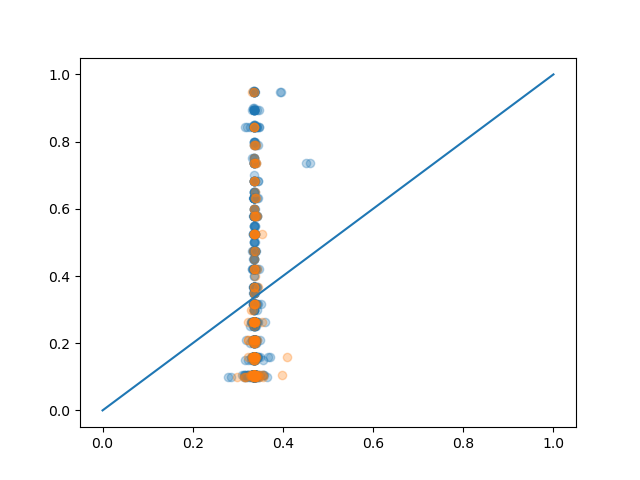

In [45]:
if interaction:
    poly = PolynomialFeatures(degree)
    test_X = poly.fit_transform(test_amps_neg)
    train_X = poly.fit_transform(train_amps_neg)

else:
    test_X = fitting.noInteractionPoly(test_amps_neg, degree)
    train_X = fitting.noInteractionPoly(train_amps_neg, degree)

test_y = test_probs_neg
train_y = train_probs_neg

fig = plt.figure(10)
fig.clear()
plt.scatter(clf.predict_proba(train_X)[:, 1], train_y, alpha=0.3)
plt.scatter(clf.predict_proba(test_X)[:, 1], test_y, alpha=0.3)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.show()

In [30]:
np.mean(np.absolute(clf.predict_proba(test_X)[:, 1] - test_y) < 0.1), np.mean(np.absolute(clf.predict_proba(test_X)[:, 1] - test_y) < 0.1)

(0.3147208121827411, 0.3147208121827411)

In [31]:
degree = 4
interaction = True
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_neg, train_trials_neg, train_amps_neg, degree, interaction
)

In [32]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [33]:
multi_weights

array([-2.18682129e+00,  1.30852502e+00,  4.16535699e-03,  2.81958569e-01,
       -1.01107857e+00, -1.47373033e+00, -1.30165926e+00,  7.93587011e-01,
       -4.46312141e-01,  3.12860091e-03,  7.34502164e-01,  9.97558645e-01,
        1.63701207e+00, -9.19038970e-01,  7.14456518e-01,  2.32642084e-01,
        2.16667351e-03, -1.94827408e-01,  3.22367912e-01, -5.82197887e-02,
       -1.54227281e-01, -2.33601942e-01, -4.76618104e-01,  3.66567006e-01,
       -3.30623368e-01, -1.82233863e-01,  2.17290883e-01,  1.99693574e-01,
       -2.16215390e-01,  2.56049052e-02, -1.85603694e-01,  1.54438043e-01,
        6.02229872e-02, -1.02015377e-01,  3.05832394e-02])

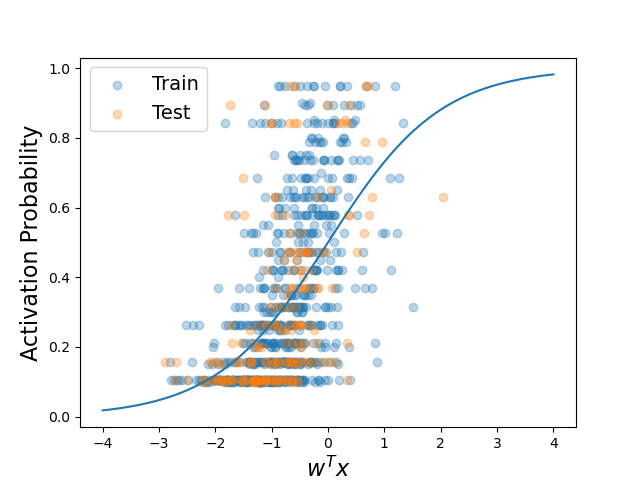

In [34]:
if interaction:
    poly = PolynomialFeatures(degree)
    test_X = poly.fit_transform(test_amps_neg)
    train_X = poly.fit_transform(train_amps_neg)

else:
    test_X = fitting.noInteractionPoly(test_amps_neg, degree)
    train_X = fitting.noInteractionPoly(train_amps_neg, degree)

test_y = test_probs_neg
train_y = train_probs_neg

plt.figure(2)
plt.figure(2).clear()
plt.scatter(train_X @ multi_weights, train_y, label='Train', alpha=0.3)
plt.scatter(test_X @ multi_weights, test_y, label='Test', alpha=0.3)
plt.xlabel(r'$w^Tx$', fontsize=16)
plt.ylabel('Activation Probability', fontsize=16)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))
plt.legend(fontsize=14)
plt.show()

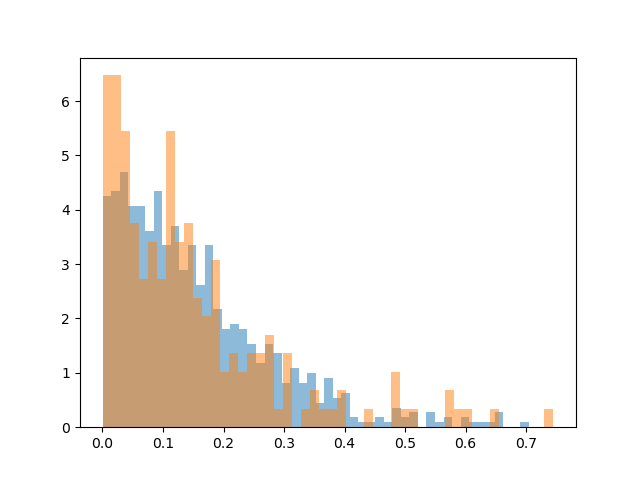

In [35]:
plt.figure(6)
plt.figure(6).clear()
plt.hist(np.absolute(fitting.fsigmoid(train_X, multi_weights) - train_y), bins=50, density=True, alpha=0.5)
plt.hist(np.absolute(fitting.fsigmoid(test_X, multi_weights) - test_y), bins=50, density=True, alpha=0.5)

plt.show()

In [ ]:
np.mean(np.absolute(fitting.fsigmoid(test_X, multi_weights) - test_y) < 0.1), np.mean(np.absolute(fitting.fsigmoid(train_X, multi_weights) - train_y) < 0.1)

In [ ]:
degree = 1
interaction = True
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_pos, train_trials_pos, train_amps_pos, degree, interaction
)

In [ ]:
multi_X.shape, multi_y.shape

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(multi_X, multi_y)

In [ ]:
if interaction:
    poly = PolynomialFeatures(degree)
    test_X = poly.fit_transform(test_amps_pos)
    train_X = poly.fit_transform(train_amps_pos)

else:
    test_X = fitting.noInteractionPoly(test_amps_pos, degree)
    train_X = fitting.noInteractionPoly(train_amps_pos, degree)

test_y = test_probs_pos
train_y = train_probs_pos

fig = plt.figure(11)
fig.clear()
plt.scatter(clf.predict_proba(train_X)[:, 1], train_y, alpha=0.3)
plt.scatter(clf.predict_proba(test_X)[:, 1], test_y, alpha=0.3)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.show()

In [ ]:
np.mean(np.absolute(clf.predict_proba(test_X)[:, 1] - test_y) < 0.1), np.mean(np.absolute(clf.predict_proba(test_X)[:, 1] - test_y) < 0.1)

In [ ]:
degree = 4
interaction = True
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_pos, train_trials_pos, train_amps_pos, degree, interaction
)

In [ ]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [ ]:
multi_weights

In [ ]:
if interaction:
    poly = PolynomialFeatures(degree)
    test_X = poly.fit_transform(test_amps_pos)
    train_X = poly.fit_transform(train_amps_pos)
    
else:
    test_X = fitting.noInteractionPoly(test_amps_pos, degree)
    train_X = fitting.noInteractionPoly(train_amps_pos, degree)

test_y = test_probs_pos
train_y = train_probs_pos

plt.figure(3)
plt.figure(3).clear()
plt.scatter(train_X @ multi_weights, train_y, label='Train', alpha=0.3)
plt.scatter(test_X @ multi_weights, test_y, label='Test', alpha=0.3)
plt.xlabel(r'$w^Tx$', fontsize=16)
plt.ylabel('Activation Probability', fontsize=16)
sigmoid_x = np.linspace(-4, 4, 100)
plt.xlim(-5, 5)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))
plt.legend(fontsize=14)
plt.show()

In [ ]:
plt.figure(7)
plt.figure(7).clear()
plt.hist(np.absolute(fitting.fsigmoid(train_X, multi_weights) - train_y), bins=50, density=True, alpha=0.5)
plt.hist(np.absolute(fitting.fsigmoid(test_X, multi_weights) - test_y), bins=50, density=True, alpha=0.5)
plt.show()

In [ ]:
np.mean(np.absolute(fitting.fsigmoid(test_X, multi_weights) - test_y) < 0.1), np.mean(np.absolute(fitting.fsigmoid(train_X, multi_weights) - train_y) < 0.1)